# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

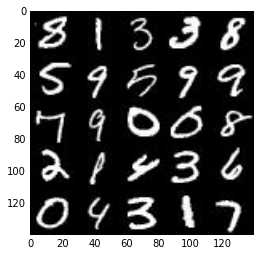

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

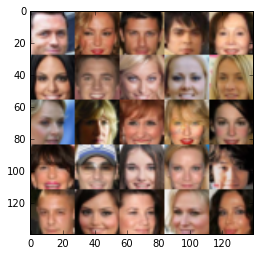

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2 
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    b, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)    
    
    print_every = 10
    show_every = 100 
    losses = []
    n_images = 25
    steps = 0
#     saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(d_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})                
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                
                if steps % print_every == 0:

                    # At the end of each epoch, get the losses and print them out                    
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, input_lr:learning_rate})                    
                

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

#         saver.save(sess, './checkpoints/generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5144... Generator Loss: 0.0424
Epoch 1/2... Discriminator Loss: 2.4534... Generator Loss: 0.1420
Epoch 1/2... Discriminator Loss: 1.9273... Generator Loss: 0.2024
Epoch 1/2... Discriminator Loss: 2.2220... Generator Loss: 0.1480
Epoch 1/2... Discriminator Loss: 2.0840... Generator Loss: 0.1863
Epoch 1/2... Discriminator Loss: 1.9725... Generator Loss: 0.1910
Epoch 1/2... Discriminator Loss: 2.0731... Generator Loss: 0.1836
Epoch 1/2... Discriminator Loss: 2.0056... Generator Loss: 0.1965
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 0.2706
Epoch 1/2... Discriminator Loss: 1.8793... Generator Loss: 0.2014


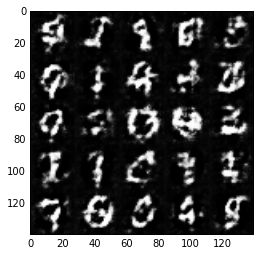

Epoch 1/2... Discriminator Loss: 2.0429... Generator Loss: 0.1835
Epoch 1/2... Discriminator Loss: 1.9048... Generator Loss: 0.2029
Epoch 1/2... Discriminator Loss: 1.9885... Generator Loss: 0.1912
Epoch 1/2... Discriminator Loss: 2.0640... Generator Loss: 0.1747
Epoch 1/2... Discriminator Loss: 1.9993... Generator Loss: 0.1893
Epoch 1/2... Discriminator Loss: 1.8787... Generator Loss: 0.2246
Epoch 1/2... Discriminator Loss: 1.8143... Generator Loss: 0.2562
Epoch 1/2... Discriminator Loss: 1.9987... Generator Loss: 0.1794
Epoch 1/2... Discriminator Loss: 2.1062... Generator Loss: 0.1600
Epoch 1/2... Discriminator Loss: 1.9689... Generator Loss: 0.2043


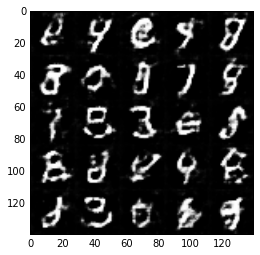

Epoch 1/2... Discriminator Loss: 1.7919... Generator Loss: 0.2571
Epoch 1/2... Discriminator Loss: 2.5718... Generator Loss: 0.1017
Epoch 1/2... Discriminator Loss: 1.9928... Generator Loss: 0.1984
Epoch 1/2... Discriminator Loss: 1.6986... Generator Loss: 0.2949
Epoch 1/2... Discriminator Loss: 1.8563... Generator Loss: 0.2274
Epoch 1/2... Discriminator Loss: 1.8070... Generator Loss: 0.2327
Epoch 1/2... Discriminator Loss: 1.5038... Generator Loss: 0.3464
Epoch 1/2... Discriminator Loss: 1.9545... Generator Loss: 0.2003
Epoch 1/2... Discriminator Loss: 1.7661... Generator Loss: 0.2589
Epoch 1/2... Discriminator Loss: 1.9081... Generator Loss: 0.2004


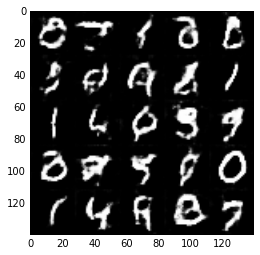

Epoch 1/2... Discriminator Loss: 2.1098... Generator Loss: 0.1722
Epoch 1/2... Discriminator Loss: 1.6970... Generator Loss: 0.2611
Epoch 1/2... Discriminator Loss: 1.7045... Generator Loss: 0.2630
Epoch 1/2... Discriminator Loss: 1.5175... Generator Loss: 0.3766
Epoch 1/2... Discriminator Loss: 2.0241... Generator Loss: 0.1649
Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.3352
Epoch 1/2... Discriminator Loss: 2.0009... Generator Loss: 0.1850
Epoch 1/2... Discriminator Loss: 1.6320... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 2.0076... Generator Loss: 0.2083
Epoch 1/2... Discriminator Loss: 1.6154... Generator Loss: 0.3097


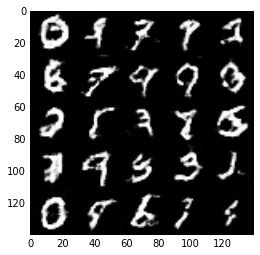

Epoch 1/2... Discriminator Loss: 1.9363... Generator Loss: 0.1981
Epoch 1/2... Discriminator Loss: 1.4977... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.5181... Generator Loss: 0.3600
Epoch 1/2... Discriminator Loss: 1.8714... Generator Loss: 0.2238
Epoch 1/2... Discriminator Loss: 2.1447... Generator Loss: 0.1590
Epoch 1/2... Discriminator Loss: 2.0938... Generator Loss: 0.1815
Epoch 1/2... Discriminator Loss: 1.4867... Generator Loss: 0.3613
Epoch 1/2... Discriminator Loss: 1.6125... Generator Loss: 0.3181
Epoch 1/2... Discriminator Loss: 2.2131... Generator Loss: 0.1429
Epoch 1/2... Discriminator Loss: 1.6640... Generator Loss: 0.2675


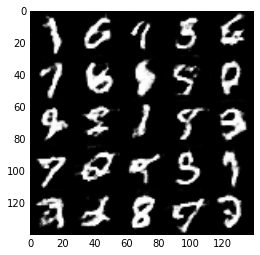

Epoch 1/2... Discriminator Loss: 2.0349... Generator Loss: 0.1801
Epoch 1/2... Discriminator Loss: 2.1925... Generator Loss: 0.1857
Epoch 1/2... Discriminator Loss: 1.9988... Generator Loss: 0.2347
Epoch 1/2... Discriminator Loss: 2.2443... Generator Loss: 0.1436
Epoch 1/2... Discriminator Loss: 1.9196... Generator Loss: 0.2060
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 2.1893... Generator Loss: 0.1643
Epoch 1/2... Discriminator Loss: 2.2036... Generator Loss: 0.1637
Epoch 1/2... Discriminator Loss: 1.9318... Generator Loss: 0.2100
Epoch 1/2... Discriminator Loss: 2.0306... Generator Loss: 0.2026


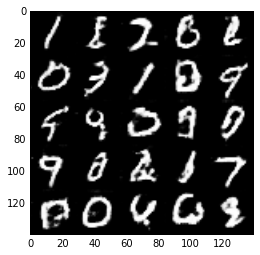

Epoch 1/2... Discriminator Loss: 1.9499... Generator Loss: 0.2048
Epoch 1/2... Discriminator Loss: 2.4707... Generator Loss: 0.1115
Epoch 1/2... Discriminator Loss: 1.7310... Generator Loss: 0.2670
Epoch 1/2... Discriminator Loss: 2.0927... Generator Loss: 0.2067
Epoch 1/2... Discriminator Loss: 2.1351... Generator Loss: 0.1711
Epoch 1/2... Discriminator Loss: 1.7205... Generator Loss: 0.2829
Epoch 1/2... Discriminator Loss: 1.0270... Generator Loss: 1.0186
Epoch 1/2... Discriminator Loss: 1.4800... Generator Loss: 0.4107
Epoch 1/2... Discriminator Loss: 1.6683... Generator Loss: 0.2949
Epoch 1/2... Discriminator Loss: 1.9599... Generator Loss: 0.2276


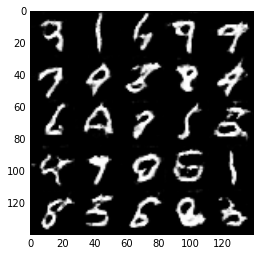

Epoch 1/2... Discriminator Loss: 1.9216... Generator Loss: 0.2146
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.6186
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.4763
Epoch 1/2... Discriminator Loss: 1.6602... Generator Loss: 0.2991
Epoch 1/2... Discriminator Loss: 2.5867... Generator Loss: 0.1168
Epoch 1/2... Discriminator Loss: 2.0852... Generator Loss: 0.1702
Epoch 1/2... Discriminator Loss: 2.3180... Generator Loss: 0.1343
Epoch 1/2... Discriminator Loss: 2.0638... Generator Loss: 0.2191
Epoch 1/2... Discriminator Loss: 2.1948... Generator Loss: 0.3878
Epoch 1/2... Discriminator Loss: 1.4304... Generator Loss: 0.3709


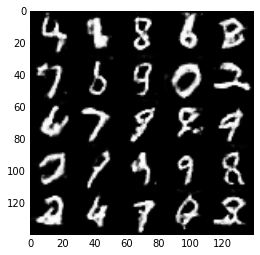

Epoch 1/2... Discriminator Loss: 1.5345... Generator Loss: 0.3216
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 0.5111
Epoch 1/2... Discriminator Loss: 0.9457... Generator Loss: 0.6962
Epoch 1/2... Discriminator Loss: 1.7543... Generator Loss: 0.2770
Epoch 1/2... Discriminator Loss: 1.6670... Generator Loss: 0.3056
Epoch 1/2... Discriminator Loss: 2.5875... Generator Loss: 0.1023
Epoch 1/2... Discriminator Loss: 2.8523... Generator Loss: 0.0893
Epoch 1/2... Discriminator Loss: 1.8668... Generator Loss: 0.2207
Epoch 1/2... Discriminator Loss: 1.7868... Generator Loss: 0.2362
Epoch 1/2... Discriminator Loss: 1.8065... Generator Loss: 0.2492


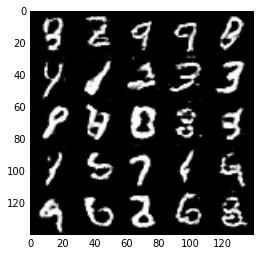

Epoch 1/2... Discriminator Loss: 1.9409... Generator Loss: 0.2365
Epoch 1/2... Discriminator Loss: 1.9569... Generator Loss: 0.2128
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 1.6112
Epoch 2/2... Discriminator Loss: 1.9093... Generator Loss: 0.2386
Epoch 2/2... Discriminator Loss: 2.1752... Generator Loss: 0.1807
Epoch 2/2... Discriminator Loss: 1.8988... Generator Loss: 0.2263
Epoch 2/2... Discriminator Loss: 1.9844... Generator Loss: 0.2189
Epoch 2/2... Discriminator Loss: 1.8650... Generator Loss: 0.2285
Epoch 2/2... Discriminator Loss: 2.2982... Generator Loss: 0.1434
Epoch 2/2... Discriminator Loss: 2.2599... Generator Loss: 0.1514


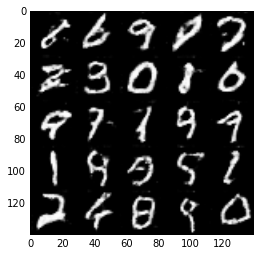

Epoch 2/2... Discriminator Loss: 1.6532... Generator Loss: 0.3193
Epoch 2/2... Discriminator Loss: 1.4436... Generator Loss: 0.3692
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 0.7273
Epoch 2/2... Discriminator Loss: 1.2056... Generator Loss: 0.5268
Epoch 2/2... Discriminator Loss: 1.3002... Generator Loss: 0.4782
Epoch 2/2... Discriminator Loss: 1.7031... Generator Loss: 0.2861
Epoch 2/2... Discriminator Loss: 2.3283... Generator Loss: 0.1540
Epoch 2/2... Discriminator Loss: 2.1244... Generator Loss: 0.1722
Epoch 2/2... Discriminator Loss: 2.3442... Generator Loss: 0.1371
Epoch 2/2... Discriminator Loss: 1.8034... Generator Loss: 0.2670


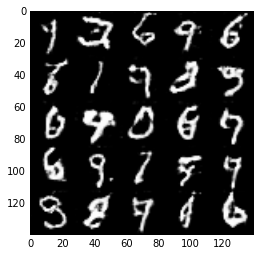

Epoch 2/2... Discriminator Loss: 2.4055... Generator Loss: 0.1409
Epoch 2/2... Discriminator Loss: 0.6215... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 0.5245
Epoch 2/2... Discriminator Loss: 2.1744... Generator Loss: 0.1644
Epoch 2/2... Discriminator Loss: 2.2689... Generator Loss: 0.1645
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 0.5872
Epoch 2/2... Discriminator Loss: 2.0778... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 1.8517... Generator Loss: 0.2580
Epoch 2/2... Discriminator Loss: 2.3014... Generator Loss: 0.1546
Epoch 2/2... Discriminator Loss: 1.2104... Generator Loss: 0.5380


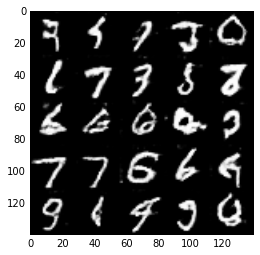

Epoch 2/2... Discriminator Loss: 1.6127... Generator Loss: 0.3068
Epoch 2/2... Discriminator Loss: 1.7277... Generator Loss: 0.2554
Epoch 2/2... Discriminator Loss: 1.8701... Generator Loss: 0.2996
Epoch 2/2... Discriminator Loss: 1.9217... Generator Loss: 0.2665
Epoch 2/2... Discriminator Loss: 1.7343... Generator Loss: 0.2644
Epoch 2/2... Discriminator Loss: 2.5053... Generator Loss: 0.1314
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.4019
Epoch 2/2... Discriminator Loss: 2.4560... Generator Loss: 0.1291
Epoch 2/2... Discriminator Loss: 1.6827... Generator Loss: 0.2940
Epoch 2/2... Discriminator Loss: 2.0788... Generator Loss: 0.1773


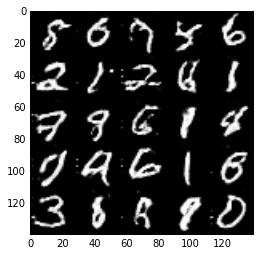

Epoch 2/2... Discriminator Loss: 4.7171... Generator Loss: 0.0215
Epoch 2/2... Discriminator Loss: 1.5663... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 2.3763... Generator Loss: 0.1500
Epoch 2/2... Discriminator Loss: 1.4516... Generator Loss: 0.3710
Epoch 2/2... Discriminator Loss: 2.2498... Generator Loss: 0.1583
Epoch 2/2... Discriminator Loss: 1.8630... Generator Loss: 0.2410
Epoch 2/2... Discriminator Loss: 1.9865... Generator Loss: 0.2579
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 0.6751
Epoch 2/2... Discriminator Loss: 0.9525... Generator Loss: 0.6948
Epoch 2/2... Discriminator Loss: 1.4551... Generator Loss: 0.4053


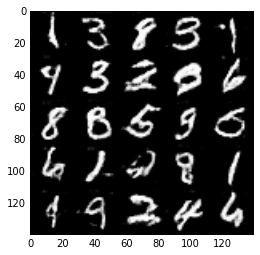

Epoch 2/2... Discriminator Loss: 1.5234... Generator Loss: 0.3414
Epoch 2/2... Discriminator Loss: 2.2876... Generator Loss: 0.1499
Epoch 2/2... Discriminator Loss: 2.2502... Generator Loss: 0.1512
Epoch 2/2... Discriminator Loss: 1.6225... Generator Loss: 0.2984
Epoch 2/2... Discriminator Loss: 0.7567... Generator Loss: 2.0180
Epoch 2/2... Discriminator Loss: 1.8162... Generator Loss: 0.2665
Epoch 2/2... Discriminator Loss: 2.4519... Generator Loss: 0.1426
Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 1.2430... Generator Loss: 0.4735
Epoch 2/2... Discriminator Loss: 2.6941... Generator Loss: 0.1116


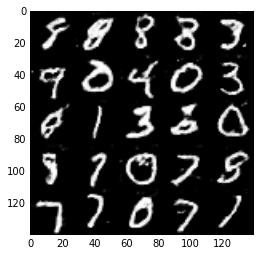

Epoch 2/2... Discriminator Loss: 1.2217... Generator Loss: 0.4970
Epoch 2/2... Discriminator Loss: 2.0564... Generator Loss: 0.1987
Epoch 2/2... Discriminator Loss: 1.9995... Generator Loss: 0.2154
Epoch 2/2... Discriminator Loss: 1.9158... Generator Loss: 0.2664
Epoch 2/2... Discriminator Loss: 2.1071... Generator Loss: 0.1988
Epoch 2/2... Discriminator Loss: 2.6331... Generator Loss: 0.3390
Epoch 2/2... Discriminator Loss: 2.0139... Generator Loss: 0.1997
Epoch 2/2... Discriminator Loss: 2.1176... Generator Loss: 0.2156
Epoch 2/2... Discriminator Loss: 2.2280... Generator Loss: 0.1946
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.1234


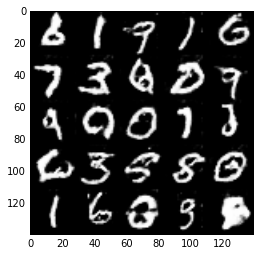

Epoch 2/2... Discriminator Loss: 0.8623... Generator Loss: 0.8831
Epoch 2/2... Discriminator Loss: 1.5563... Generator Loss: 0.3612
Epoch 2/2... Discriminator Loss: 2.2896... Generator Loss: 0.1494
Epoch 2/2... Discriminator Loss: 2.0828... Generator Loss: 0.1896
Epoch 2/2... Discriminator Loss: 1.9292... Generator Loss: 0.2095
Epoch 2/2... Discriminator Loss: 2.3374... Generator Loss: 0.1421
Epoch 2/2... Discriminator Loss: 2.5257... Generator Loss: 0.1339
Epoch 2/2... Discriminator Loss: 2.3189... Generator Loss: 0.1820
Epoch 2/2... Discriminator Loss: 2.2579... Generator Loss: 0.1455
Epoch 2/2... Discriminator Loss: 0.6084... Generator Loss: 1.5174


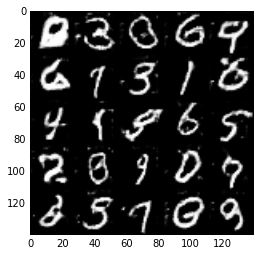

Epoch 2/2... Discriminator Loss: 2.0388... Generator Loss: 0.2347
Epoch 2/2... Discriminator Loss: 2.4870... Generator Loss: 0.1373
Epoch 2/2... Discriminator Loss: 2.6417... Generator Loss: 0.1214
Epoch 2/2... Discriminator Loss: 2.7191... Generator Loss: 0.1028
Epoch 2/2... Discriminator Loss: 3.0126... Generator Loss: 0.0721
Epoch 2/2... Discriminator Loss: 4.3090... Generator Loss: 5.6882
Epoch 2/2... Discriminator Loss: 1.7571... Generator Loss: 0.3125
Epoch 2/2... Discriminator Loss: 2.0829... Generator Loss: 0.1914
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 2.6688... Generator Loss: 0.1346


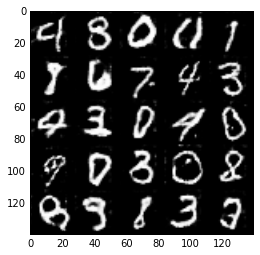

Epoch 2/2... Discriminator Loss: 2.6321... Generator Loss: 0.1009
Epoch 2/2... Discriminator Loss: 1.5206... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 2.4919... Generator Loss: 0.1590
Epoch 2/2... Discriminator Loss: 2.2888... Generator Loss: 0.1547
Epoch 2/2... Discriminator Loss: 2.5016... Generator Loss: 0.1253
Epoch 2/2... Discriminator Loss: 1.7639... Generator Loss: 0.3438
Epoch 2/2... Discriminator Loss: 2.6287... Generator Loss: 0.1074


In [12]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5166... Generator Loss: 0.0504
Epoch 1/1... Discriminator Loss: 0.9983... Generator Loss: 4.8591
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5373
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 2.2558... Generator Loss: 0.1952
Epoch 1/1... Discriminator Loss: 2.2293... Generator Loss: 0.1788
Epoch 1/1... Discriminator Loss: 2.6303... Generator Loss: 0.1252
Epoch 1/1... Discriminator Loss: 2.1583... Generator Loss: 0.1845
Epoch 1/1... Discriminator Loss: 2.5306... Generator Loss: 0.1312
Epoch 1/1... Discriminator Loss: 2.2571... Generator Loss: 0.1694


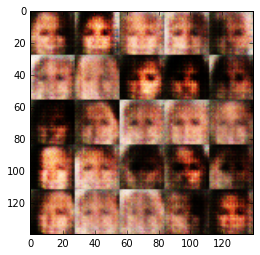

Epoch 1/1... Discriminator Loss: 2.2504... Generator Loss: 0.1568
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.3114
Epoch 1/1... Discriminator Loss: 2.1116... Generator Loss: 0.2184
Epoch 1/1... Discriminator Loss: 1.9376... Generator Loss: 0.2880
Epoch 1/1... Discriminator Loss: 1.7924... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 1.7012... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.4092
Epoch 1/1... Discriminator Loss: 1.8219... Generator Loss: 0.3048
Epoch 1/1... Discriminator Loss: 1.8049... Generator Loss: 0.3228
Epoch 1/1... Discriminator Loss: 1.8820... Generator Loss: 0.2814


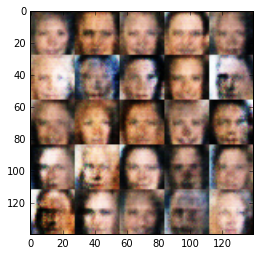

Epoch 1/1... Discriminator Loss: 1.7990... Generator Loss: 0.2969
Epoch 1/1... Discriminator Loss: 1.8228... Generator Loss: 0.2964
Epoch 1/1... Discriminator Loss: 2.0806... Generator Loss: 0.2209
Epoch 1/1... Discriminator Loss: 1.9170... Generator Loss: 0.2705
Epoch 1/1... Discriminator Loss: 1.8245... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 1.7550... Generator Loss: 0.3762
Epoch 1/1... Discriminator Loss: 1.8907... Generator Loss: 0.2733
Epoch 1/1... Discriminator Loss: 1.7238... Generator Loss: 0.3567
Epoch 1/1... Discriminator Loss: 1.8730... Generator Loss: 0.2853
Epoch 1/1... Discriminator Loss: 1.7025... Generator Loss: 0.3411


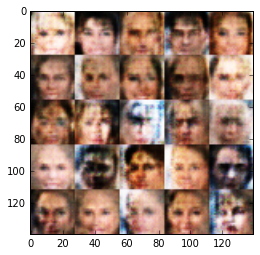

Epoch 1/1... Discriminator Loss: 1.9145... Generator Loss: 0.2549
Epoch 1/1... Discriminator Loss: 1.7551... Generator Loss: 0.3106
Epoch 1/1... Discriminator Loss: 1.8617... Generator Loss: 0.2902
Epoch 1/1... Discriminator Loss: 1.8055... Generator Loss: 0.2973
Epoch 1/1... Discriminator Loss: 1.8867... Generator Loss: 0.2555
Epoch 1/1... Discriminator Loss: 1.7223... Generator Loss: 0.3496
Epoch 1/1... Discriminator Loss: 1.7923... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.3546
Epoch 1/1... Discriminator Loss: 1.6943... Generator Loss: 0.3373
Epoch 1/1... Discriminator Loss: 1.8013... Generator Loss: 0.2753


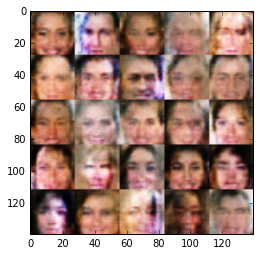

Epoch 1/1... Discriminator Loss: 2.0282... Generator Loss: 0.2283
Epoch 1/1... Discriminator Loss: 1.8237... Generator Loss: 0.3053
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 0.3067
Epoch 1/1... Discriminator Loss: 1.7534... Generator Loss: 0.3059
Epoch 1/1... Discriminator Loss: 1.6624... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.8033... Generator Loss: 0.2992
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 0.3362
Epoch 1/1... Discriminator Loss: 1.8057... Generator Loss: 0.2926
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 0.3249
Epoch 1/1... Discriminator Loss: 1.6855... Generator Loss: 0.3302


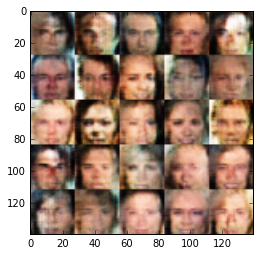

Epoch 1/1... Discriminator Loss: 1.7007... Generator Loss: 0.2939
Epoch 1/1... Discriminator Loss: 1.9679... Generator Loss: 0.2431
Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 0.3116
Epoch 1/1... Discriminator Loss: 1.6289... Generator Loss: 0.3435
Epoch 1/1... Discriminator Loss: 1.9146... Generator Loss: 0.2567
Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.2779
Epoch 1/1... Discriminator Loss: 1.7707... Generator Loss: 0.3159
Epoch 1/1... Discriminator Loss: 1.8393... Generator Loss: 0.2763
Epoch 1/1... Discriminator Loss: 1.9328... Generator Loss: 0.2625
Epoch 1/1... Discriminator Loss: 1.8332... Generator Loss: 0.2625


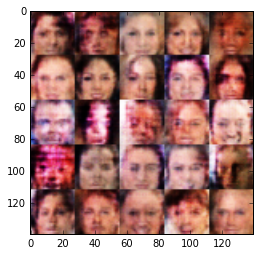

Epoch 1/1... Discriminator Loss: 1.9190... Generator Loss: 0.2675
Epoch 1/1... Discriminator Loss: 1.9593... Generator Loss: 0.2225
Epoch 1/1... Discriminator Loss: 1.8654... Generator Loss: 0.2494
Epoch 1/1... Discriminator Loss: 1.7513... Generator Loss: 0.3145
Epoch 1/1... Discriminator Loss: 1.9747... Generator Loss: 0.2312
Epoch 1/1... Discriminator Loss: 1.8559... Generator Loss: 0.2687
Epoch 1/1... Discriminator Loss: 1.8616... Generator Loss: 0.2983
Epoch 1/1... Discriminator Loss: 1.9353... Generator Loss: 0.2490
Epoch 1/1... Discriminator Loss: 1.7828... Generator Loss: 0.2908
Epoch 1/1... Discriminator Loss: 1.7417... Generator Loss: 0.3283


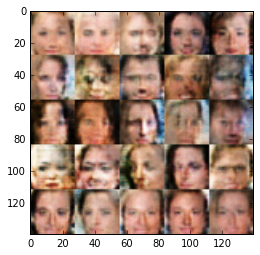

Epoch 1/1... Discriminator Loss: 1.8651... Generator Loss: 0.2654
Epoch 1/1... Discriminator Loss: 1.8621... Generator Loss: 0.2890
Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.3381
Epoch 1/1... Discriminator Loss: 1.8121... Generator Loss: 0.2780
Epoch 1/1... Discriminator Loss: 1.7400... Generator Loss: 0.3274
Epoch 1/1... Discriminator Loss: 1.8172... Generator Loss: 0.2656
Epoch 1/1... Discriminator Loss: 1.7994... Generator Loss: 0.2984
Epoch 1/1... Discriminator Loss: 1.7594... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.8600... Generator Loss: 0.2668
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.3069


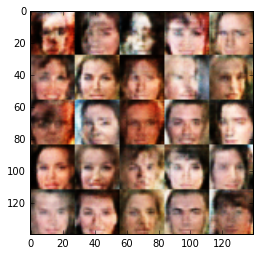

Epoch 1/1... Discriminator Loss: 1.7728... Generator Loss: 0.2871
Epoch 1/1... Discriminator Loss: 1.8257... Generator Loss: 0.2696
Epoch 1/1... Discriminator Loss: 1.8137... Generator Loss: 0.2557
Epoch 1/1... Discriminator Loss: 1.8888... Generator Loss: 0.2504
Epoch 1/1... Discriminator Loss: 1.7642... Generator Loss: 0.2869
Epoch 1/1... Discriminator Loss: 1.8537... Generator Loss: 0.2652
Epoch 1/1... Discriminator Loss: 1.9138... Generator Loss: 0.2570
Epoch 1/1... Discriminator Loss: 1.9662... Generator Loss: 0.2446
Epoch 1/1... Discriminator Loss: 1.9869... Generator Loss: 0.2433
Epoch 1/1... Discriminator Loss: 1.7274... Generator Loss: 0.3618


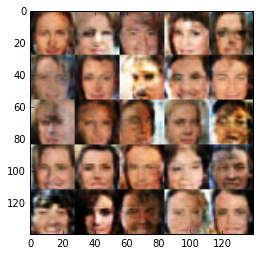

Epoch 1/1... Discriminator Loss: 1.7747... Generator Loss: 0.2725
Epoch 1/1... Discriminator Loss: 1.9340... Generator Loss: 0.2325
Epoch 1/1... Discriminator Loss: 1.8977... Generator Loss: 0.2535
Epoch 1/1... Discriminator Loss: 1.8154... Generator Loss: 0.2754
Epoch 1/1... Discriminator Loss: 1.8794... Generator Loss: 0.2612
Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 0.3343
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.3390
Epoch 1/1... Discriminator Loss: 1.9330... Generator Loss: 0.2534
Epoch 1/1... Discriminator Loss: 1.9527... Generator Loss: 0.2076
Epoch 1/1... Discriminator Loss: 1.8613... Generator Loss: 0.2542


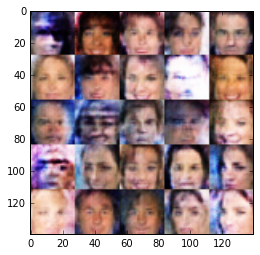

Epoch 1/1... Discriminator Loss: 1.8908... Generator Loss: 0.2453
Epoch 1/1... Discriminator Loss: 1.8850... Generator Loss: 0.2547
Epoch 1/1... Discriminator Loss: 1.9151... Generator Loss: 0.2346
Epoch 1/1... Discriminator Loss: 2.0223... Generator Loss: 0.2318
Epoch 1/1... Discriminator Loss: 1.9737... Generator Loss: 0.2279
Epoch 1/1... Discriminator Loss: 2.1958... Generator Loss: 0.1816
Epoch 1/1... Discriminator Loss: 1.9556... Generator Loss: 0.2406
Epoch 1/1... Discriminator Loss: 1.8075... Generator Loss: 0.2641
Epoch 1/1... Discriminator Loss: 1.9114... Generator Loss: 0.2397
Epoch 1/1... Discriminator Loss: 2.0852... Generator Loss: 0.1925


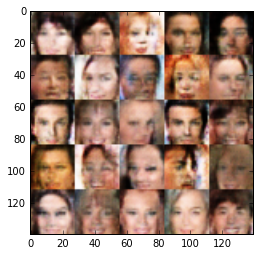

Epoch 1/1... Discriminator Loss: 2.0924... Generator Loss: 0.2041
Epoch 1/1... Discriminator Loss: 1.8209... Generator Loss: 0.2498
Epoch 1/1... Discriminator Loss: 1.9498... Generator Loss: 0.2305
Epoch 1/1... Discriminator Loss: 1.9552... Generator Loss: 0.2301
Epoch 1/1... Discriminator Loss: 1.9807... Generator Loss: 0.2272
Epoch 1/1... Discriminator Loss: 1.8538... Generator Loss: 0.2537
Epoch 1/1... Discriminator Loss: 1.9913... Generator Loss: 0.2246
Epoch 1/1... Discriminator Loss: 2.0195... Generator Loss: 0.2061
Epoch 1/1... Discriminator Loss: 1.9488... Generator Loss: 0.2465
Epoch 1/1... Discriminator Loss: 1.8715... Generator Loss: 0.2503


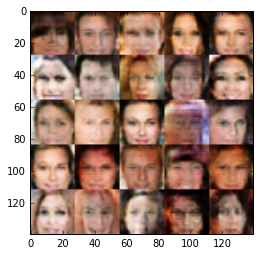

Epoch 1/1... Discriminator Loss: 2.0313... Generator Loss: 0.2134
Epoch 1/1... Discriminator Loss: 1.9295... Generator Loss: 0.2731
Epoch 1/1... Discriminator Loss: 2.2260... Generator Loss: 0.1774
Epoch 1/1... Discriminator Loss: 1.9654... Generator Loss: 0.2234
Epoch 1/1... Discriminator Loss: 1.9455... Generator Loss: 0.2486
Epoch 1/1... Discriminator Loss: 2.1322... Generator Loss: 0.1968
Epoch 1/1... Discriminator Loss: 1.8711... Generator Loss: 0.2489
Epoch 1/1... Discriminator Loss: 2.1143... Generator Loss: 0.1843
Epoch 1/1... Discriminator Loss: 1.9772... Generator Loss: 0.2018
Epoch 1/1... Discriminator Loss: 1.9866... Generator Loss: 0.2179


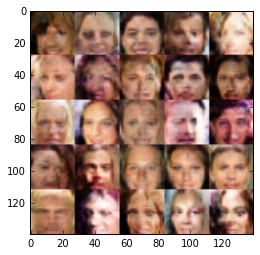

Epoch 1/1... Discriminator Loss: 2.0304... Generator Loss: 0.2193
Epoch 1/1... Discriminator Loss: 2.0077... Generator Loss: 0.2135
Epoch 1/1... Discriminator Loss: 1.9756... Generator Loss: 0.2284
Epoch 1/1... Discriminator Loss: 1.9720... Generator Loss: 0.2299
Epoch 1/1... Discriminator Loss: 1.6860... Generator Loss: 0.2924
Epoch 1/1... Discriminator Loss: 2.1923... Generator Loss: 0.1761
Epoch 1/1... Discriminator Loss: 1.8526... Generator Loss: 0.2455
Epoch 1/1... Discriminator Loss: 1.8969... Generator Loss: 0.2348
Epoch 1/1... Discriminator Loss: 1.9254... Generator Loss: 0.2378
Epoch 1/1... Discriminator Loss: 2.0177... Generator Loss: 0.2036


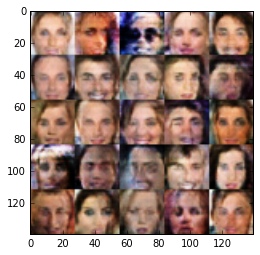

Epoch 1/1... Discriminator Loss: 2.1360... Generator Loss: 0.1907
Epoch 1/1... Discriminator Loss: 1.9613... Generator Loss: 0.2152
Epoch 1/1... Discriminator Loss: 2.0141... Generator Loss: 0.2166
Epoch 1/1... Discriminator Loss: 1.9416... Generator Loss: 0.2184
Epoch 1/1... Discriminator Loss: 2.1026... Generator Loss: 0.1867
Epoch 1/1... Discriminator Loss: 1.9369... Generator Loss: 0.2321
Epoch 1/1... Discriminator Loss: 1.8514... Generator Loss: 0.2561
Epoch 1/1... Discriminator Loss: 2.0754... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 2.0856... Generator Loss: 0.1832
Epoch 1/1... Discriminator Loss: 1.9489... Generator Loss: 0.2195


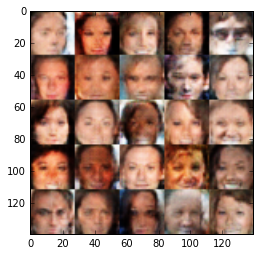

Epoch 1/1... Discriminator Loss: 2.3381... Generator Loss: 0.1644
Epoch 1/1... Discriminator Loss: 2.0543... Generator Loss: 0.1897
Epoch 1/1... Discriminator Loss: 1.9749... Generator Loss: 0.2255
Epoch 1/1... Discriminator Loss: 1.9535... Generator Loss: 0.2170
Epoch 1/1... Discriminator Loss: 1.7571... Generator Loss: 0.2685
Epoch 1/1... Discriminator Loss: 1.9929... Generator Loss: 0.2130
Epoch 1/1... Discriminator Loss: 2.0899... Generator Loss: 0.2006
Epoch 1/1... Discriminator Loss: 2.1377... Generator Loss: 0.1918
Epoch 1/1... Discriminator Loss: 2.0034... Generator Loss: 0.2062
Epoch 1/1... Discriminator Loss: 2.3679... Generator Loss: 0.1483


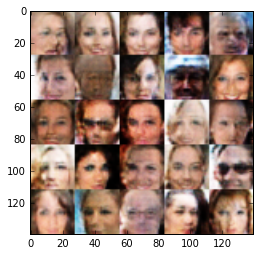

Epoch 1/1... Discriminator Loss: 2.0883... Generator Loss: 0.1991
Epoch 1/1... Discriminator Loss: 2.1520... Generator Loss: 0.1654
Epoch 1/1... Discriminator Loss: 2.1108... Generator Loss: 0.1884
Epoch 1/1... Discriminator Loss: 2.1303... Generator Loss: 0.1922
Epoch 1/1... Discriminator Loss: 2.0463... Generator Loss: 0.2066
Epoch 1/1... Discriminator Loss: 1.8966... Generator Loss: 0.2336
Epoch 1/1... Discriminator Loss: 2.0131... Generator Loss: 0.1974
Epoch 1/1... Discriminator Loss: 2.2240... Generator Loss: 0.1564
Epoch 1/1... Discriminator Loss: 1.9859... Generator Loss: 0.2270
Epoch 1/1... Discriminator Loss: 2.1505... Generator Loss: 0.1902


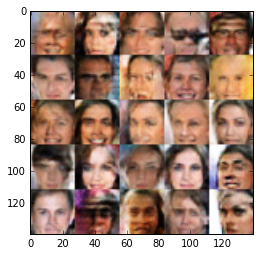

Epoch 1/1... Discriminator Loss: 2.0227... Generator Loss: 0.2261
Epoch 1/1... Discriminator Loss: 2.0482... Generator Loss: 0.2000
Epoch 1/1... Discriminator Loss: 2.1293... Generator Loss: 0.1825
Epoch 1/1... Discriminator Loss: 1.9606... Generator Loss: 0.2090
Epoch 1/1... Discriminator Loss: 1.8616... Generator Loss: 0.2567
Epoch 1/1... Discriminator Loss: 2.0074... Generator Loss: 0.1982
Epoch 1/1... Discriminator Loss: 2.2120... Generator Loss: 0.1819
Epoch 1/1... Discriminator Loss: 2.2620... Generator Loss: 0.1591
Epoch 1/1... Discriminator Loss: 1.9459... Generator Loss: 0.2234
Epoch 1/1... Discriminator Loss: 1.9709... Generator Loss: 0.2224


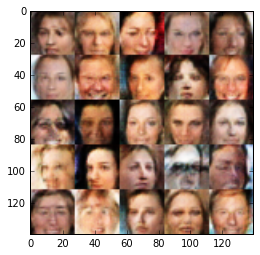

Epoch 1/1... Discriminator Loss: 2.1893... Generator Loss: 0.1626
Epoch 1/1... Discriminator Loss: 2.0418... Generator Loss: 0.2012
Epoch 1/1... Discriminator Loss: 1.9408... Generator Loss: 0.2200
Epoch 1/1... Discriminator Loss: 1.9941... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 2.0762... Generator Loss: 0.2010
Epoch 1/1... Discriminator Loss: 2.0931... Generator Loss: 0.1840
Epoch 1/1... Discriminator Loss: 2.1615... Generator Loss: 0.1727
Epoch 1/1... Discriminator Loss: 2.1794... Generator Loss: 0.1648
Epoch 1/1... Discriminator Loss: 1.9681... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 2.1300... Generator Loss: 0.1702


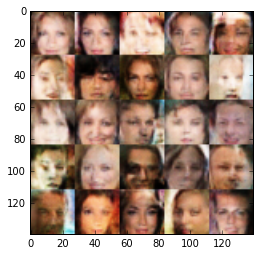

Epoch 1/1... Discriminator Loss: 1.8891... Generator Loss: 0.2486
Epoch 1/1... Discriminator Loss: 2.5016... Generator Loss: 0.1304
Epoch 1/1... Discriminator Loss: 1.9694... Generator Loss: 0.2233
Epoch 1/1... Discriminator Loss: 2.1518... Generator Loss: 0.1656
Epoch 1/1... Discriminator Loss: 2.0720... Generator Loss: 0.2026
Epoch 1/1... Discriminator Loss: 2.0199... Generator Loss: 0.1943
Epoch 1/1... Discriminator Loss: 2.2283... Generator Loss: 0.1492
Epoch 1/1... Discriminator Loss: 1.9462... Generator Loss: 0.2267
Epoch 1/1... Discriminator Loss: 2.0570... Generator Loss: 0.1817
Epoch 1/1... Discriminator Loss: 1.9859... Generator Loss: 0.1991


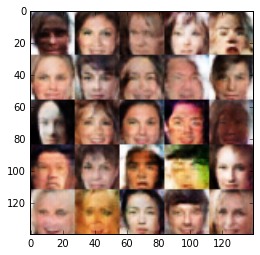

Epoch 1/1... Discriminator Loss: 2.0917... Generator Loss: 0.1771
Epoch 1/1... Discriminator Loss: 1.9137... Generator Loss: 0.2235
Epoch 1/1... Discriminator Loss: 1.8513... Generator Loss: 0.2466
Epoch 1/1... Discriminator Loss: 2.0396... Generator Loss: 0.1875
Epoch 1/1... Discriminator Loss: 2.1158... Generator Loss: 0.2051
Epoch 1/1... Discriminator Loss: 2.0161... Generator Loss: 0.2073
Epoch 1/1... Discriminator Loss: 2.2066... Generator Loss: 0.1632
Epoch 1/1... Discriminator Loss: 2.0083... Generator Loss: 0.2132
Epoch 1/1... Discriminator Loss: 2.2464... Generator Loss: 0.1555
Epoch 1/1... Discriminator Loss: 2.0647... Generator Loss: 0.1985


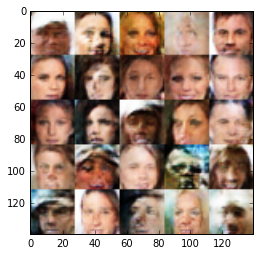

Epoch 1/1... Discriminator Loss: 1.9927... Generator Loss: 0.2040
Epoch 1/1... Discriminator Loss: 2.2398... Generator Loss: 0.1675
Epoch 1/1... Discriminator Loss: 2.0007... Generator Loss: 0.2122
Epoch 1/1... Discriminator Loss: 1.9545... Generator Loss: 0.2198
Epoch 1/1... Discriminator Loss: 2.3406... Generator Loss: 0.1299
Epoch 1/1... Discriminator Loss: 1.9982... Generator Loss: 0.1887
Epoch 1/1... Discriminator Loss: 2.3740... Generator Loss: 0.1335
Epoch 1/1... Discriminator Loss: 2.0136... Generator Loss: 0.1880
Epoch 1/1... Discriminator Loss: 2.2087... Generator Loss: 0.1638
Epoch 1/1... Discriminator Loss: 2.2710... Generator Loss: 0.1682


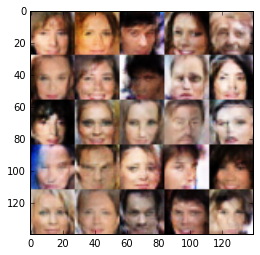

Epoch 1/1... Discriminator Loss: 2.1750... Generator Loss: 0.1673
Epoch 1/1... Discriminator Loss: 2.0420... Generator Loss: 0.2051
Epoch 1/1... Discriminator Loss: 2.0754... Generator Loss: 0.1866
Epoch 1/1... Discriminator Loss: 2.0730... Generator Loss: 0.1812
Epoch 1/1... Discriminator Loss: 2.3055... Generator Loss: 0.1449
Epoch 1/1... Discriminator Loss: 2.0246... Generator Loss: 0.2019
Epoch 1/1... Discriminator Loss: 2.5755... Generator Loss: 0.1034
Epoch 1/1... Discriminator Loss: 2.2345... Generator Loss: 0.1643
Epoch 1/1... Discriminator Loss: 2.2049... Generator Loss: 0.1515
Epoch 1/1... Discriminator Loss: 2.3258... Generator Loss: 0.1435


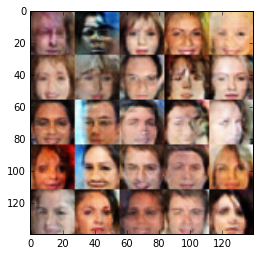

Epoch 1/1... Discriminator Loss: 2.3709... Generator Loss: 0.1384
Epoch 1/1... Discriminator Loss: 2.3115... Generator Loss: 0.1463
Epoch 1/1... Discriminator Loss: 2.1226... Generator Loss: 0.1650
Epoch 1/1... Discriminator Loss: 2.3236... Generator Loss: 0.1429
Epoch 1/1... Discriminator Loss: 3.0287... Generator Loss: 0.0907
Epoch 1/1... Discriminator Loss: 2.2510... Generator Loss: 0.1681
Epoch 1/1... Discriminator Loss: 2.0977... Generator Loss: 0.1872
Epoch 1/1... Discriminator Loss: 2.0947... Generator Loss: 0.1693
Epoch 1/1... Discriminator Loss: 2.0701... Generator Loss: 0.1826
Epoch 1/1... Discriminator Loss: 2.2295... Generator Loss: 0.1574


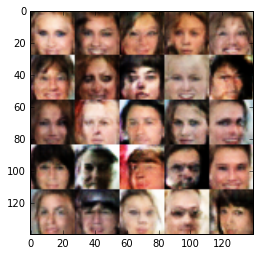

Epoch 1/1... Discriminator Loss: 2.1743... Generator Loss: 0.1709
Epoch 1/1... Discriminator Loss: 2.1034... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 2.1569... Generator Loss: 0.1823
Epoch 1/1... Discriminator Loss: 2.1499... Generator Loss: 0.1655
Epoch 1/1... Discriminator Loss: 2.0115... Generator Loss: 0.1881
Epoch 1/1... Discriminator Loss: 2.1235... Generator Loss: 0.1807
Epoch 1/1... Discriminator Loss: 2.3626... Generator Loss: 0.1285
Epoch 1/1... Discriminator Loss: 1.9789... Generator Loss: 0.2039
Epoch 1/1... Discriminator Loss: 2.0992... Generator Loss: 0.1860
Epoch 1/1... Discriminator Loss: 2.3086... Generator Loss: 0.1462


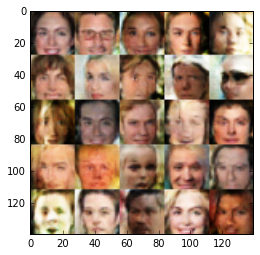

Epoch 1/1... Discriminator Loss: 2.1469... Generator Loss: 0.1521
Epoch 1/1... Discriminator Loss: 2.1187... Generator Loss: 0.1935
Epoch 1/1... Discriminator Loss: 2.2983... Generator Loss: 0.1483
Epoch 1/1... Discriminator Loss: 2.0022... Generator Loss: 0.1807
Epoch 1/1... Discriminator Loss: 2.1650... Generator Loss: 0.1733
Epoch 1/1... Discriminator Loss: 2.1857... Generator Loss: 0.1557
Epoch 1/1... Discriminator Loss: 2.2473... Generator Loss: 0.1671
Epoch 1/1... Discriminator Loss: 2.2968... Generator Loss: 0.1339
Epoch 1/1... Discriminator Loss: 2.4679... Generator Loss: 0.1224
Epoch 1/1... Discriminator Loss: 2.2919... Generator Loss: 0.1488


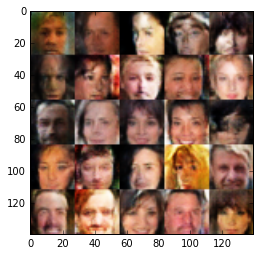

Epoch 1/1... Discriminator Loss: 1.9063... Generator Loss: 0.2259
Epoch 1/1... Discriminator Loss: 2.1208... Generator Loss: 0.1871
Epoch 1/1... Discriminator Loss: 2.2110... Generator Loss: 0.1584
Epoch 1/1... Discriminator Loss: 2.0386... Generator Loss: 0.1887
Epoch 1/1... Discriminator Loss: 2.2498... Generator Loss: 0.1573
Epoch 1/1... Discriminator Loss: 2.1351... Generator Loss: 0.1657
Epoch 1/1... Discriminator Loss: 1.9690... Generator Loss: 0.2017
Epoch 1/1... Discriminator Loss: 1.9527... Generator Loss: 0.2168
Epoch 1/1... Discriminator Loss: 2.4059... Generator Loss: 0.1472
Epoch 1/1... Discriminator Loss: 2.0932... Generator Loss: 0.1787


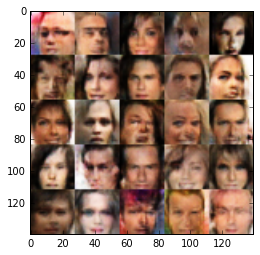

Epoch 1/1... Discriminator Loss: 2.2034... Generator Loss: 0.1588
Epoch 1/1... Discriminator Loss: 2.2190... Generator Loss: 0.1548
Epoch 1/1... Discriminator Loss: 2.0508... Generator Loss: 0.1909
Epoch 1/1... Discriminator Loss: 1.9486... Generator Loss: 0.2133
Epoch 1/1... Discriminator Loss: 1.9867... Generator Loss: 0.2105
Epoch 1/1... Discriminator Loss: 2.5721... Generator Loss: 0.1150
Epoch 1/1... Discriminator Loss: 1.9984... Generator Loss: 0.2151
Epoch 1/1... Discriminator Loss: 2.2216... Generator Loss: 0.1528
Epoch 1/1... Discriminator Loss: 2.0635... Generator Loss: 0.1917
Epoch 1/1... Discriminator Loss: 2.1709... Generator Loss: 0.1704


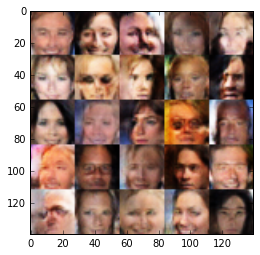

Epoch 1/1... Discriminator Loss: 2.0296... Generator Loss: 0.1855
Epoch 1/1... Discriminator Loss: 2.1306... Generator Loss: 0.1633
Epoch 1/1... Discriminator Loss: 2.4238... Generator Loss: 0.1206
Epoch 1/1... Discriminator Loss: 2.1549... Generator Loss: 0.1598
Epoch 1/1... Discriminator Loss: 2.2532... Generator Loss: 0.1554
Epoch 1/1... Discriminator Loss: 2.2167... Generator Loss: 0.1567
Epoch 1/1... Discriminator Loss: 2.0875... Generator Loss: 0.1832
Epoch 1/1... Discriminator Loss: 2.1535... Generator Loss: 0.1682
Epoch 1/1... Discriminator Loss: 2.1927... Generator Loss: 0.1534
Epoch 1/1... Discriminator Loss: 2.2846... Generator Loss: 0.1420


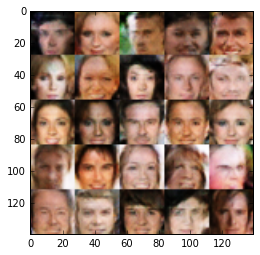

Epoch 1/1... Discriminator Loss: 2.1287... Generator Loss: 0.1731
Epoch 1/1... Discriminator Loss: 1.9202... Generator Loss: 0.2206
Epoch 1/1... Discriminator Loss: 2.2315... Generator Loss: 0.1531
Epoch 1/1... Discriminator Loss: 2.0413... Generator Loss: 0.1952
Epoch 1/1... Discriminator Loss: 2.2214... Generator Loss: 0.1469
Epoch 1/1... Discriminator Loss: 1.9693... Generator Loss: 0.1980
Epoch 1/1... Discriminator Loss: 2.0728... Generator Loss: 0.1944
Epoch 1/1... Discriminator Loss: 2.0840... Generator Loss: 0.1808
Epoch 1/1... Discriminator Loss: 2.1194... Generator Loss: 0.1724
Epoch 1/1... Discriminator Loss: 2.2685... Generator Loss: 0.1460


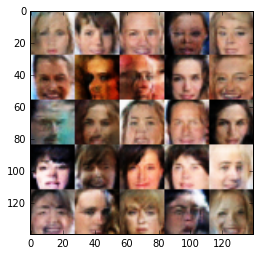

Epoch 1/1... Discriminator Loss: 2.2169... Generator Loss: 0.1574
Epoch 1/1... Discriminator Loss: 1.9995... Generator Loss: 0.1886
Epoch 1/1... Discriminator Loss: 2.2463... Generator Loss: 0.1339
Epoch 1/1... Discriminator Loss: 2.1355... Generator Loss: 0.1760
Epoch 1/1... Discriminator Loss: 1.9691... Generator Loss: 0.2099
Epoch 1/1... Discriminator Loss: 2.7897... Generator Loss: 0.0853
Epoch 1/1... Discriminator Loss: 2.2439... Generator Loss: 0.1558
Epoch 1/1... Discriminator Loss: 2.2914... Generator Loss: 0.1427
Epoch 1/1... Discriminator Loss: 2.2238... Generator Loss: 0.1596
Epoch 1/1... Discriminator Loss: 2.3846... Generator Loss: 0.1309


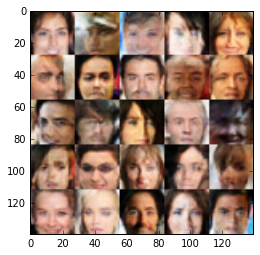

Epoch 1/1... Discriminator Loss: 2.6297... Generator Loss: 0.1047
Epoch 1/1... Discriminator Loss: 1.9681... Generator Loss: 0.2047
Epoch 1/1... Discriminator Loss: 2.5238... Generator Loss: 0.1128
Epoch 1/1... Discriminator Loss: 2.4688... Generator Loss: 0.1106
Epoch 1/1... Discriminator Loss: 2.2993... Generator Loss: 0.1478
Epoch 1/1... Discriminator Loss: 1.8842... Generator Loss: 0.2182


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.